#HW8 - Cyclic Voltammetry

In [5]:
# imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9, 6]
matplotlib.rcParams['font.size'] = 11
import numpy as np

The following is a simulation of cyclic voltammetry. It solves Fick's second law using numerical integration in both space and time. Fick's second law states

\begin{equation}\Large
\frac{\partial C(x, t)}{\partial t} = D \frac{\partial^2 C(x, t)}{\partial x^2}
\end{equation}

To integrate this numerically, we need expressions for the first and second derivatives that relate points in space and time starting with knowledge of the initial concentrations and concentration gradients.

If we define a series of $(x_i, y_i, z_i)$ values for different times ($x_0$ is the first x position, $y_0$ is the first y position, $z_0$ is the first z position), then we can establish the first two sets of $x, y, z$ points so $(x_0, y_0, z_0)$ will be the first position and $(x_1, y_1, z_1)$ will be the second position. The distance between $(x_0, y_0, z_0)$ and $(x_1, y_1, z_1)$ will be related to the velocity of the particle and its direction. The third position and all others after it can then be determined by using a numerical approximation for the derivative. If

\begin{equation}\Large
\left(\frac{d C}{d t}\right)_i = \frac{C_{i+1}-C_i}{\delta t}
\end{equation}

<center>and</center>

\begin{equation}\Large
\left(\frac{d C}{d x}\right)_i = \frac{C_{i+1}-C_i}{\delta x}
\end{equation}

<center>then</center>

\begin{equation}\Large
\left(\frac{d^2 C}{d x^2}\right)_i = \frac{\frac{d C_i}{dx}-\frac{d C_{i-1}}{dx}}{\delta x} = \frac{C_{i+1} - 2C_i + C_{i-1}}{\delta x^2}
\end{equation}

Notice that the second derivative is the derivative of the first derivative. The second derivative does have a small error associated with it. A more correct approach would use the Crank-Nicolson method. Substituting these expressions into Fick's second law will allow you to relate the values of the first three points. Since you know the first two $(x, y, z)$ points (you choose those values by picking the initial position and velocity), you can find the third point. Once you know the third point, you can find the fourth point etc. That allows you to find all the points.

A word of caution: the time increment, $\delta t$ can't be too large or the procedure will have errors that will accumulate and cause large discrepancies. You can check to see if the increment is too large by choosing a smaller one and seeing if the points change appreciably.

[None, None, None, None, None, None, None, None, None, None]

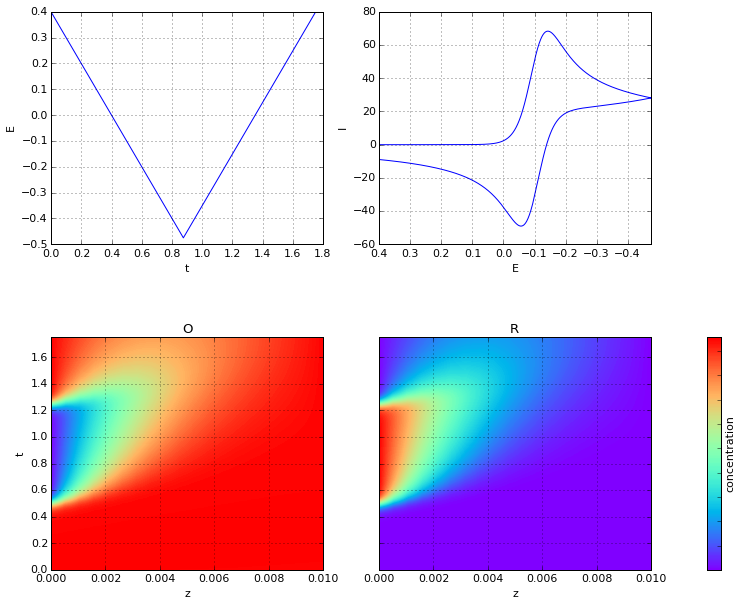

In [6]:
# simulation variables
t = np.linspace(0, 1.75, 3.5e3)
z = np.linspace(0, 0.01, 20)
dt = t[1]-t[0]
dz = z[1]-z[0]

# E(t)
Ei = 0.4  # initial 
v = 1. # rate
E = np.zeros(len(t))
turnaround_index = len(t)/2
E[:turnaround_index] = Ei-v*t[:turnaround_index]  # decending region
E[turnaround_index:] = Ei-v*0.5*t.max()+v*t[:turnaround_index]  # ascending region

F = 96500.
R = 8.314
T = 300.
a = F/(R*T)
n = 1.
E0 = -0.1

# R and O arrays
CR = 1e-5  # initial R concentration
CO = 0.1  # initial O concentration
DR = 1e-5  # R diffusion coefficient 
DO = DR  # O diffusion coefficient
# R and O are concentration arrays in (space, time)
R = np.zeros([len(z), len(t)])
O = np.zeros([len(z), len(t)])
# set concentration in all space for zero time
R[:, 0] = CR
O[:, 0] = CO
# set concentration for all time at furthest distance from electrode
R[-1, :] = CR
O[-1, :] = CO
for j in range(1, len(t)):
    R[0, j] = (1./(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    O[0, j] = ((np.exp(n*a*(E[j]-E0)))/(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    for i in range(1, len(z)-1):
        R[i, j] = R[i, j-1]+(dt*DR*(R[i+1, j-1]-2*R[i, j-1]+R[i-1, j-1]))/(dz**2)
        O[i, j] = O[i, j-1]+(dt*DO*(O[i+1, j-1]-2*O[i, j-1]+O[i-1, j-1]))/(dz**2)

# prepare to plot
fig = plt.figure(figsize=[12, 10])
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=[20, 20, 1], wspace=0.3, hspace=0.4)

# potential
plt.subplot(gs[0])
plt.plot(t, E)
plt.xlabel('t')
plt.ylabel('E')
plt.grid()

# current
plt.subplot(gs[1])
area = 1.
I = n*F*area*DO*(O[1]-O[0])/dz
plt.plot(E, I)
plt.xlim(E.max(), E.min())
plt.xlabel('E')
plt.ylabel('I')
plt.grid()

# O
axO = plt.subplot(gs[3])
cax = axO.contourf(z, t, O.T, 200, cmap='rainbow')
axO.set_title('O')
axO.set_xlabel('z')
axO.set_ylabel('t')
axO.grid()

# R
axR = plt.subplot(gs[4])
cax = axR.contourf(z, t, R.T, 200, cmap='rainbow')
axR.set_title('R')
axR.set_xlabel('z')
plt.setp(axR.get_yticklabels(), visible=False)
axR.grid()

# colorbar
axc = plt.subplot(gs[5])
plt.colorbar(cax, cax=axc, label='concentration')
plt.setp(axc.get_yticklabels(), visible=False)

## 1
You first need to understand the simulation. Briefly explain the logic guiding each step and how it applies to the numerical integration of Fick's second law, the current, and the concentrations of the oxidized and reduced species. Justify the equations that are used in the program.

First we create arrays for t and z, and the spacing between the points (dt and dz). We then calculate the point at which you reverse the potential, and fill the potential array with values stepping up and then down with time.
After that we set our constants, starting concentrations, and diffusion coefficients. We then have to set the boundary conditions, C=C_i at t=0 and C=C_i at x final (bulk). Using this, we start to fill the array, starting with all the times at x=0. We do this by getting a fraction of O and R stepping forward from the t=0 values, then multipling this by the combined concentrations at the previous point.
The last step is to fill the array at all the remaining x between x=0 and bulk. We do this using the numerical approximation of Fick's second law and advancing point by point in the loop.
Finally, we set up a figure and plot each graph as a subplot within it!

## 2
What do $i$ and $j$ represent in the program? What information is contained in the contour plots and how does that information relate to the concepts discussed in class?

i represents the distance from the electrode, starting from x=1 since x=0 has already been solved for, and j represents the time coordinate.
The contour plots contain 3 dimensional arrays that show the concentration as a function of both the time evolution, t, and the distance from the electrode, x. This contains all of the time points on the CV plot that allow us to do individual plots of concentrations at each distinct feature of the CV plot.

## 3
Compare the voltammograms for different numbers of electrons in the half reactions. The separation between the reductive and oxidative peaks is expected to be 0.0591/n. Find whether your simulations reproduce this expectation. Any difference could be attributed to the error introduced by not using the Crank-Nicolson method.

E differences*n: [ 0.08627465  0.09752787  0.10578022  0.11303229]


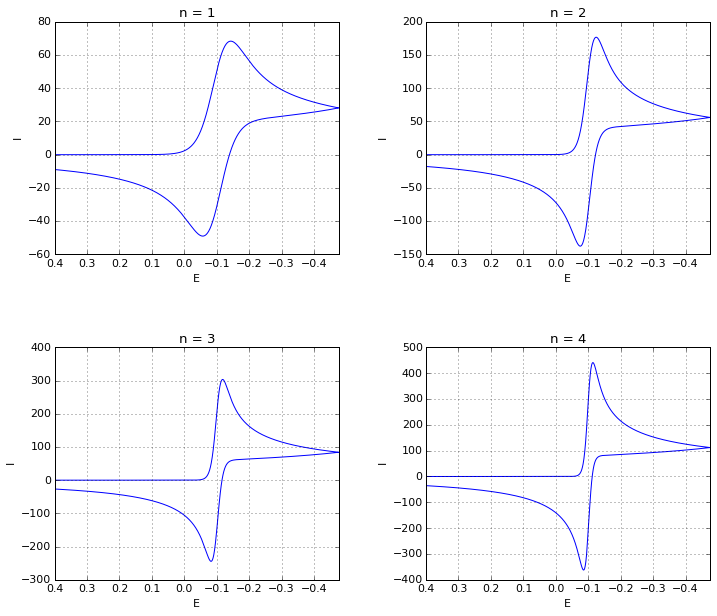

In [18]:
# simulation variables
t = np.linspace(0, 1.75, 3.5e3)
z = np.linspace(0, 0.01, 20)
dt = t[1]-t[0]
dz = z[1]-z[0]

# E(t)
Ei = 0.4  # initial 
v = 1. # rate
E = np.zeros(len(t))
turnaround_index = len(t)/2
E[:turnaround_index] = Ei-v*t[:turnaround_index]  # decending region
E[turnaround_index:] = Ei-v*0.5*t.max()+v*t[:turnaround_index]  # ascending region

# prepare to plot
fig = plt.figure(figsize=[12, 10])
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[20, 20, 1], wspace=0.3, hspace=0.4)

# find difference b/w peaks
Formal_potential = np.zeros(4)

for y in range(1,5):

    F = 96500.
    R = 8.314
    T = 300.
    a = F/(R*T)
    n = float(y)
    E0 = -0.1

    # R and O arrays
    CR = 1e-5  # initial R concentration
    CO = 0.1  # initial O concentration
    DR = 1e-5  # R diffusion coefficient 
    DO = DR  # O diffusion coefficient
    # R and O are concentration arrays in (space, time)
    R = np.zeros([len(z), len(t)])
    O = np.zeros([len(z), len(t)])
    # set concentration in all space for zero time
    R[:, 0] = CR
    O[:, 0] = CO
    # set concentration for all time at furthest distance from electrode
    R[-1, :] = CR
    O[-1, :] = CO
    for j in range(1, len(t)):
        R[0, j] = (1./(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
        O[0, j] = ((np.exp(n*a*(E[j]-E0)))/(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
        for i in range(1, len(z)-1):
            R[i, j] = R[i, j-1]+(dt*DR*(R[i+1, j-1]-2*R[i, j-1]+R[i-1, j-1]))/(dz**2)
            O[i, j] = O[i, j-1]+(dt*DO*(O[i+1, j-1]-2*O[i, j-1]+O[i-1, j-1]))/(dz**2)
    

    I = n*F*area*DO*(O[1]-O[0])/dz
    Formal_potential[y-1]= (E[np.argmin(I)]-E[np.argmax(I)])*n

    # current
    plt.subplot(gs[y-1])
    area = 1.
    plt.plot(E, I)
    plt.xlim(E.max(), E.min())
    plt.title('n = '+str(y))
    plt.xlabel('E')
    plt.ylabel('I')
    plt.grid()
    
print 'E differences*n:', Formal_potential

The values for my differences are larger than the expected value of 0.059/n, and they get worse as n increases.

## 4
Compare the voltammograms obtained for different scan rates. Describe how they differ and provide an explanation for the differences.

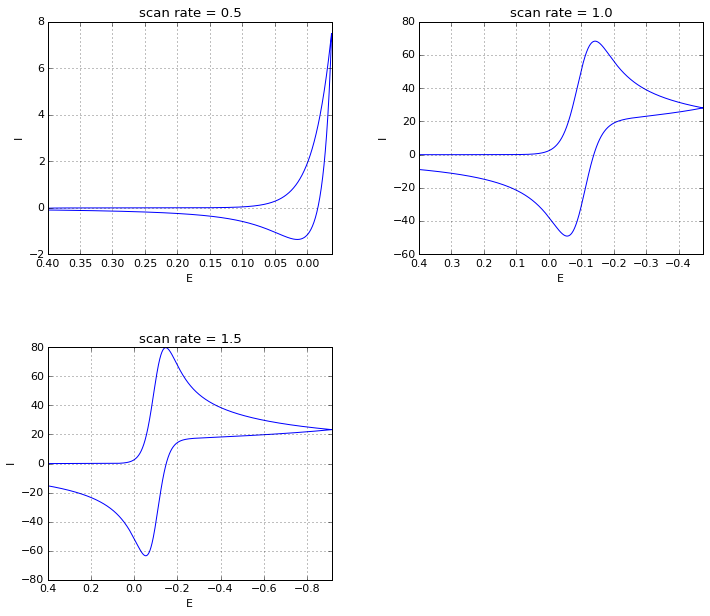

In [22]:
# simulation variables
t = np.linspace(0, 1.75, 3.5e3)
z = np.linspace(0, 0.01, 20)
dt = t[1]-t[0]
dz = z[1]-z[0]

# prepare to plot
fig = plt.figure(figsize=[12, 10])
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[20, 20, 1], wspace=0.3, hspace=0.4)

for y in range(1,4):

    # E(t)
    Ei = 0.4  # initial 
    v = float(y)/2. # rate
    E = np.zeros(len(t))
    turnaround_index = len(t)/2
    E[:turnaround_index] = Ei-v*t[:turnaround_index]  # decending region
    E[turnaround_index:] = Ei-v*0.5*t.max()+v*t[:turnaround_index]  # ascending region

    F = 96500.
    R = 8.314
    T = 300.
    a = F/(R*T)
    n = 1.
    E0 = -0.1

    # R and O arrays
    CR = 1e-5  # initial R concentration
    CO = 0.1  # initial O concentration
    DR = 1e-5  # R diffusion coefficient 
    DO = DR  # O diffusion coefficient
    # R and O are concentration arrays in (space, time)
    R = np.zeros([len(z), len(t)])
    O = np.zeros([len(z), len(t)])
    # set concentration in all space for zero time
    R[:, 0] = CR
    O[:, 0] = CO
    # set concentration for all time at furthest distance from electrode
    R[-1, :] = CR
    O[-1, :] = CO
    for j in range(1, len(t)):
        R[0, j] = (1./(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
        O[0, j] = ((np.exp(n*a*(E[j]-E0)))/(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
        for i in range(1, len(z)-1):
            R[i, j] = R[i, j-1]+(dt*DR*(R[i+1, j-1]-2*R[i, j-1]+R[i-1, j-1]))/(dz**2)
            O[i, j] = O[i, j-1]+(dt*DO*(O[i+1, j-1]-2*O[i, j-1]+O[i-1, j-1]))/(dz**2)
    

    I = n*F*area*DO*(O[1]-O[0])/dz

    # current
    plt.subplot(gs[y-1])
    area = 1.
    plt.plot(E, I)
    plt.xlim(E.max(), E.min())
    plt.title('scan rate = '+str(v))
    plt.xlabel('E')
    plt.ylabel('I')
    plt.grid()

## 5
Graph the concentration gradients for the points indicated in the graph shown below. Do the gradients match what you expected from the discussion in lecture? Several of the points occur at the same voltage. Describe what causes the differences in currents.

<img src="CV_points.png" width="400">

2587


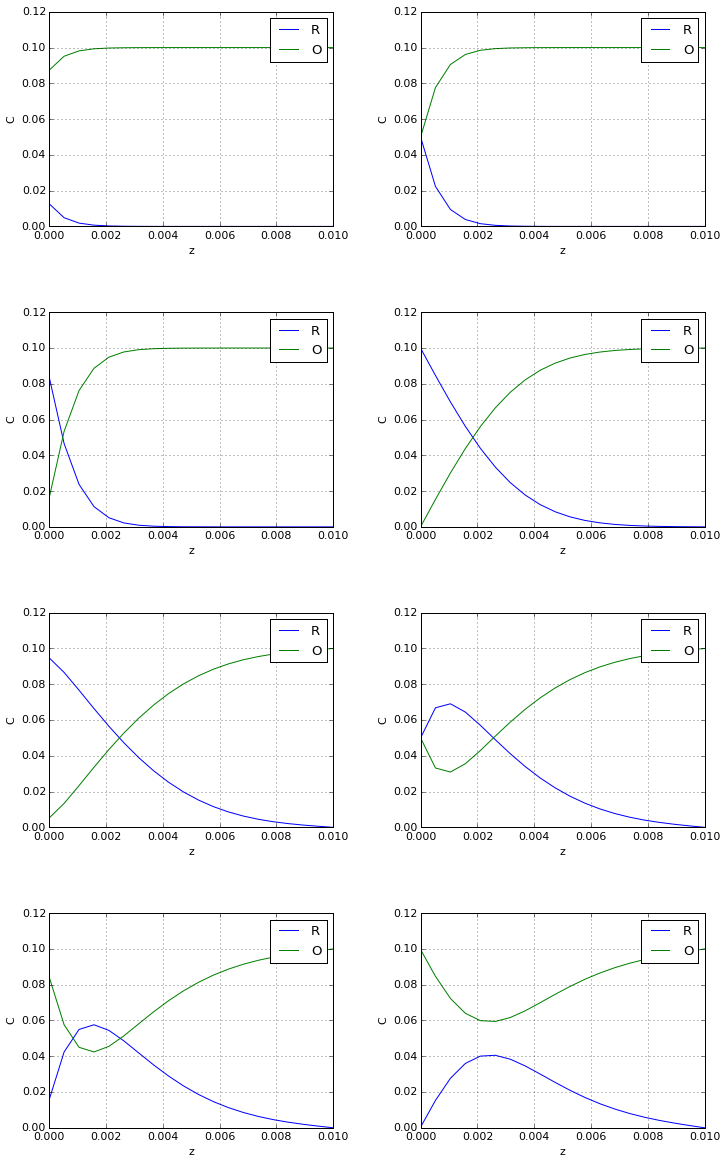

In [37]:
# simulation variables
t = np.linspace(0, 1.75, 3.5e3)
z = np.linspace(0, 0.01, 20)
dt = t[1]-t[0]
dz = z[1]-z[0]

# E(t)
Ei = 0.4  # initial 
v = 1. # rate
E = np.zeros(len(t))
turnaround_index = len(t)/2
E[:turnaround_index] = Ei-v*t[:turnaround_index]  # decending region
E[turnaround_index:] = Ei-v*0.5*t.max()+v*t[:turnaround_index]  # ascending region

F = 96500.
R = 8.314
T = 300.
a = F/(R*T)
n = 1.
E0 = -0.1

# R and O arrays
CR = 1e-5  # initial R concentration
CO = 0.1  # initial O concentration
DR = 1e-5  # R diffusion coefficient 
DO = DR  # O diffusion coefficient
# R and O are concentration arrays in (space, time)
R = np.zeros([len(z), len(t)])
O = np.zeros([len(z), len(t)])
# set concentration in all space for zero time
R[:, 0] = CR
O[:, 0] = CO
# set concentration for all time at furthest distance from electrode
R[-1, :] = CR
O[-1, :] = CO
for j in range(1, len(t)):
    R[0, j] = (1./(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    O[0, j] = ((np.exp(n*a*(E[j]-E0)))/(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    for i in range(1, len(z)-1):
        R[i, j] = R[i, j-1]+(dt*DR*(R[i+1, j-1]-2*R[i, j-1]+R[i-1, j-1]))/(dz**2)
        O[i, j] = O[i, j-1]+(dt*DO*(O[i+1, j-1]-2*O[i, j-1]+O[i-1, j-1]))/(dz**2)
        
I = n*F*area*DO*(O[1]-O[0])/dz
Formal_potential = (E[np.argmin(I)]-E[np.argmax(I)])

# prepare to plot
fig = plt.figure(figsize=[12, 20])
gs = matplotlib.gridspec.GridSpec(4, 2, width_ratios=[20, 20, 1], wspace=0.3, hspace=0.4)

# plots!
y = 900
plt.subplot(gs[0])
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

y = 1000
plt.subplot(gs[1])
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

y = np.argmax(I)
plt.subplot(gs[2])
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

y = np.argmin(E)
plt.subplot(gs[3])
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

y = 2350
plt.subplot(gs[4])
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

y = 2500
plt.subplot(gs[5])
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

y = np.argmin(I)
plt.subplot(gs[6])
print y
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

y = 2800
plt.subplot(gs[7])
area = 1.
plt.plot(z, R[:,y])
plt.plot(z, O[:,y])
plt.xlabel('z')
plt.ylabel('C')
plt.legend(['R','O'])
plt.grid()

## 6
Convert the simulation so it now simulates a single direction voltage scan from +0.4 V to -0.45 V. The simulation assumes the oxidized form of the molecule is dominant. Graph the voltammogram when the oxidized and reduced forms of the molecule are both present in equal amounts.

[None, None, None, None, None, None, None, None, None, None]

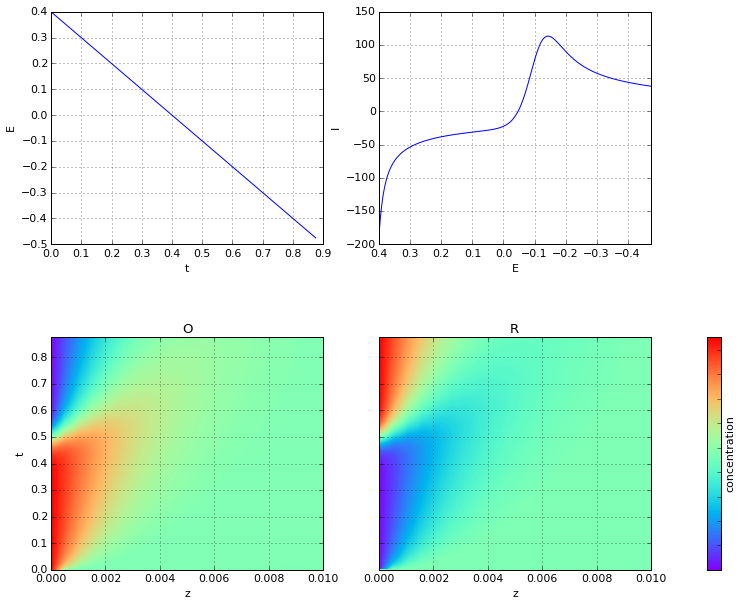

In [25]:
# simulation variables
t = np.linspace(0, 1.75/2, 3.5e3/2)
z = np.linspace(0, 0.01, 20)
dt = t[1]-t[0]
dz = z[1]-z[0]

# E(t)
Ei = 0.4  # initial 
v = 1. # rate
E = np.zeros(len(t))
E = Ei-v*t  # decending region

F = 96500.
R = 8.314
T = 300.
a = F/(R*T)
n = 1.
E0 = -0.1

# R and O arrays
CR = 0.1  # initial R concentration
CO = 0.1  # initial O concentration
DR = 1e-5  # R diffusion coefficient 
DO = DR  # O diffusion coefficient
# R and O are concentration arrays in (space, time)
R = np.zeros([len(z), len(t)])
O = np.zeros([len(z), len(t)])
# set concentration in all space for zero time
R[:, 0] = CR
O[:, 0] = CO
# set concentration for all time at furthest distance from electrode
R[-1, :] = CR
O[-1, :] = CO
for j in range(1, len(t)):
    R[0, j] = (1./(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    O[0, j] = ((np.exp(n*a*(E[j]-E0)))/(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    for i in range(1, len(z)-1):
        R[i, j] = R[i, j-1]+(dt*DR*(R[i+1, j-1]-2*R[i, j-1]+R[i-1, j-1]))/(dz**2)
        O[i, j] = O[i, j-1]+(dt*DO*(O[i+1, j-1]-2*O[i, j-1]+O[i-1, j-1]))/(dz**2)

# prepare to plot
fig = plt.figure(figsize=[12, 10])
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=[20, 20, 1], wspace=0.3, hspace=0.4)

# potential
plt.subplot(gs[0])
plt.plot(t, E)
plt.xlabel('t')
plt.ylabel('E')
plt.grid()

# current
plt.subplot(gs[1])
area = 1.
I = n*F*area*DO*(O[1]-O[0])/dz
plt.plot(E, I)
plt.xlim(E.max(), E.min())
plt.xlabel('E')
plt.ylabel('I')
plt.grid()

# O
axO = plt.subplot(gs[3])
cax = axO.contourf(z, t, O.T, 200, cmap='rainbow')
axO.set_title('O')
axO.set_xlabel('z')
axO.set_ylabel('t')
axO.grid()

# R
axR = plt.subplot(gs[4])
cax = axR.contourf(z, t, R.T, 200, cmap='rainbow')
axR.set_title('R')
axR.set_xlabel('z')
plt.setp(axR.get_yticklabels(), visible=False)
axR.grid()

# colorbar
axc = plt.subplot(gs[5])
plt.colorbar(cax, cax=axc, label='concentration')
plt.setp(axc.get_yticklabels(), visible=False)

## 7
Now convert the simulation so it simulates a pulse voltammogram where the potential is 0.4 V and it is suddenly switched to -0.2 V for a given time (determined by you) and then returned to 0.4 V. Use the same concentrations of oxidized and reduced forms as you started with.

[None, None, None, None, None, None, None, None, None, None]

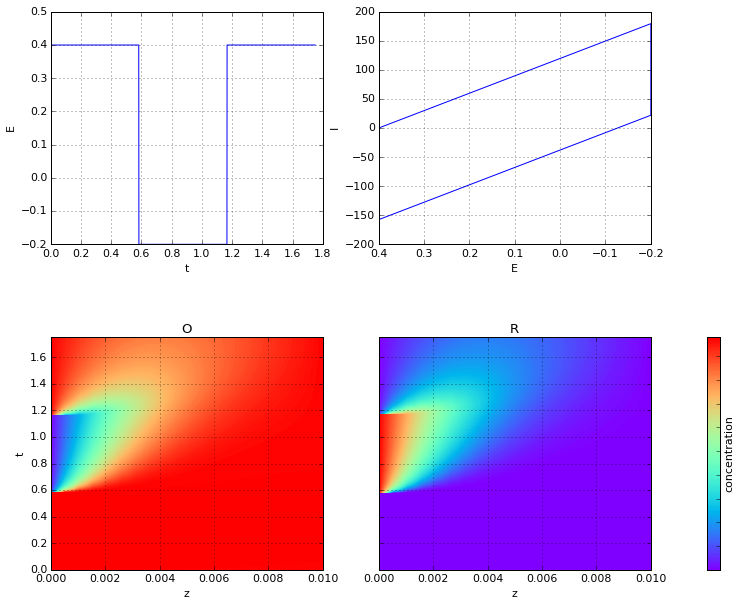

In [26]:
# simulation variables
t = np.linspace(0, 1.75, 3.5e3)
z = np.linspace(0, 0.01, 20)
dt = t[1]-t[0]
dz = z[1]-z[0]

# E(t)
Ei = 0.4  # initial 
v = 1. # rate
E = np.zeros(len(t))
turnaround_index = len(t)/3
E[:turnaround_index] = Ei
E[turnaround_index:turnaround_index*2] = -0.2
E[turnaround_index*2:] = Ei

F = 96500.
R = 8.314
T = 300.
a = F/(R*T)
n = 1.
E0 = -0.1

# R and O arrays
CR = 1e-5  # initial R concentration
CO = 0.1  # initial O concentration
DR = 1e-5  # R diffusion coefficient 
DO = DR  # O diffusion coefficient
# R and O are concentration arrays in (space, time)
R = np.zeros([len(z), len(t)])
O = np.zeros([len(z), len(t)])
# set concentration in all space for zero time
R[:, 0] = CR
O[:, 0] = CO
# set concentration for all time at furthest distance from electrode
R[-1, :] = CR
O[-1, :] = CO
for j in range(1, len(t)):
    R[0, j] = (1./(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    O[0, j] = ((np.exp(n*a*(E[j]-E0)))/(1+np.exp(n*a*(E[j]-E0))))*(O[0, j-1]+R[0, j-1])
    for i in range(1, len(z)-1):
        R[i, j] = R[i, j-1]+(dt*DR*(R[i+1, j-1]-2*R[i, j-1]+R[i-1, j-1]))/(dz**2)
        O[i, j] = O[i, j-1]+(dt*DO*(O[i+1, j-1]-2*O[i, j-1]+O[i-1, j-1]))/(dz**2)

# prepare to plot
fig = plt.figure(figsize=[12, 10])
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=[20, 20, 1], wspace=0.3, hspace=0.4)

# potential
plt.subplot(gs[0])
plt.plot(t, E)
plt.xlabel('t')
plt.ylabel('E')
plt.grid()

# current
plt.subplot(gs[1])
area = 1.
I = n*F*area*DO*(O[1]-O[0])/dz
plt.plot(E, I)
plt.xlim(E.max(), E.min())
plt.xlabel('E')
plt.ylabel('I')
plt.grid()

# O
axO = plt.subplot(gs[3])
cax = axO.contourf(z, t, O.T, 200, cmap='rainbow')
axO.set_title('O')
axO.set_xlabel('z')
axO.set_ylabel('t')
axO.grid()

# R
axR = plt.subplot(gs[4])
cax = axR.contourf(z, t, R.T, 200, cmap='rainbow')
axR.set_title('R')
axR.set_xlabel('z')
plt.setp(axR.get_yticklabels(), visible=False)
axR.grid()

# colorbar
axc = plt.subplot(gs[5])
plt.colorbar(cax, cax=axc, label='concentration')
plt.setp(axc.get_yticklabels(), visible=False)